In [17]:
import os
import sys
#sys.path.append('D:\ProgramData\Anaconda3\envs\KKeras\Lib\site-packages')
import csv
import cv2
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split

## 处理数据文件名称列表

In [18]:
print(os.path.abspath('__file__'))

lines = []
with open('./data/driving_log.csv') as csvfile:  # 相对路径，用./
    csvsheet = csv.reader(csvfile)
    for line in csvsheet:
        lines.append(line)

lines = lines[1:-1]  # Remove the title line
print(lines[0]) # show the first effective data, the structure should be 
                # [center pic], [left pic], [right pic], [steering],[throttle],[brake],[speed]

/home/bolin/Desktop/CarND-Behavioral-Cloning-P3/__file__
['IMG/center_2016_12_01_13_30_48_287.jpg', ' IMG/left_2016_12_01_13_30_48_287.jpg', ' IMG/right_2016_12_01_13_30_48_287.jpg', ' 0', ' 0', ' 0', ' 22.14829']


## 数据集生成

In [19]:
images = []
images_rz = []
measurements = []
for line in lines:
    source_path = line[0]       # 看CSV，表里面第一项是地址
    #print(source_path)
    pic_name = source_path.split('/')[-1] #被‘/’分割后的最后一项
    #print(pic_name)
    current_path ='./data/IMG/'+pic_name
    image = cv2.imread(current_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)# 因为cv2读取的是BGR因此要转换成RGB显示才正常,包括drive.py使用也是
  #  image_rz = cv2.resize(image,(160,160),cv2.INTER_AREA) #取中间有效部分然后缩放
  #  images_rz.append(image_rz)
    images.append(image)
    measurement = float(line[3])
    measurements.append(measurement) # get all the steering angle

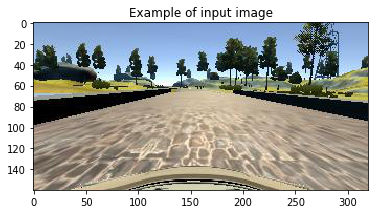

In [20]:
plt.imshow(images[1]) 
plt.title('Example of input image')
plt.show()

#plt.imshow(images_rz[1]) 
#plt.title('Example after Resize')
#plt.show()

In [21]:
X_train = np.array(images)
#X_train = np.array(images)
Y_train = np.array(measurements)

train_samples, validation_samples = train_test_split(lines,test_size =0.2)

## Generator分割数据 

In [37]:
def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1:
        shuffle(samples)
        for offset in range(0,num_samples,batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images =[]
            angles =[]
            for batch_sample in batch_samples:
                name ='./data/IMG/'+batch_sample[0].split('/')[-1] # the name of the pic
                center_image = cv2.imread(name)
                center_image = cv2.cvtColor(center_image, cv2.COLOR_BGR2RGB)
                center_angle = float(batch_sample[3])
                images.append(center_image)
                angles.append(center_angle)
                
            X_train = np.array(images)
            Y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)
            
train_generator = generator(train_samples,batch_size = 32)
validation_generator = generator(validation_samples, batch_size = 32)



## 数据准备完毕，开始构建网络

In [38]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout
from keras.layers.convolutional import Convolution2D, Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import Cropping2D


In [39]:
#Build Model
model = Sequential()
#Pre-processing
model.add(Lambda(lambda x: x / 255 - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((50, 20), (0, 0))))
# NIVIDIA End to End Learning for Self-Driving Cars， Figure（4）
# First Conv, 24*5*5
model.add(Conv2D(24, 5, strides=(2, 2), activation='relu'))
model.add(Dropout(0.7))
# Second Conv, 36*5*5
model.add(Conv2D(36, 5, strides=(2, 2), activation='relu'))
# Thrid Conv, 48*5*5
model.add(Conv2D(48, 5, strides=(2, 2), activation='relu'))
# Fourth Conv, 64*5*5
model.add(Conv2D(64, 3, activation='relu'))
model.add(Conv2D(64, 3, activation='relu'))
model.add(Flatten())
# Four Fully-Connected layers
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

In [45]:
#Run the Model
model.compile(loss = 'mse', optimizer = 'adam') #Regression问题，而不是Classification问

#history_object = model.fit(X_train, Y_train,validation_split = 0.2, shuffle = True, epochs = 5, verbose = 1)
history_object = model.fit_generator(train_generator, steps_per_epoch = len(train_samples),validation_data = validation_generator,validation_steps = len(validation_samples), epochs = 5, verbose = 1, shuffle = False)
#history_object = model.fit_generator(train_generator, steps_per_epoch = len(train_samples),validation_data = validation_generator,nb_val_samples = len(validation_samples), nb_epoch = 5)


print(history_object.history.keys())
### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()


model.save('model.h5')

Epoch 1/5


StopIteration: 